## Start of what was originally in the other notebook

In [ ]:
import os
import django
os.environ.setdefault('DJANGO_SETTINGS_MODULE', '/Users/keithmitchell/Desktop/Repositories/NeuroMabSeq/trimmer/trimmer/settings.py')
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
django.setup()

In [ ]:
from django.contrib.auth.models import User
from sequence_db.models import TrimmerEntry
from sequence_db.models import TrimmerSequence
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import plotly.express as px
from scipy import stats
# increase the number of columns shown in the dataframe for jupyter
pd.set_option('display.max_columns', 500)


# Aberrant chain counts and figures
1. Load data
2. Plot
3. Save


In [ ]:
abber = pd.read_csv("jupyter/abber_counts.tsv", sep="\t")
abber = abber[~abber["Chain"].isna()]
#abber["PctAber"] = abber["Aberrant_LC_reads"]/(abber["ReadsWithPrimer"] + abber["Aberrant_LC_reads"]) * 100
abber["PctAber"] = abber["Aberrant_LC_reads"]/(abber["ReadsWithPrimer"]) * 100
abber[abber["Chain"]=="L"]

,plate,Chain,SMARTindex,RawReads,ReadsWithPrimer,Ga12HC,Ga3HC,LaLC,KaLC,ReadsToFilter,PassedAberrantFilter,Aberrant_LC_reads,ReadsToOverlap,ShortInsert,MediumInserts,LongInserts,Overlapped,LengthFiltered,PctAber
97,TRIMMER0002_P2,L,01-SMARTindex,571113.0,618.0,0.0,0.0,6.0,612.0,618.0,618.0,115.0,618.0,443.0,125.0,50.0,568.0,119.0,18.608414
98,TRIMMER0002_P2,L,02-SMARTindex,571113.0,6043.0,0.0,0.0,16.0,6027.0,6043.0,6043.0,1182.0,6043.0,362.0,5452.0,229.0,5814.0,5401.0,19.559821
99,TRIMMER0002_P2,L,03-SMARTindex,571113.0,5064.0,0.0,0.0,12.0,5052.0,5064.0,5064.0,876.0,5064.0,321.0,4491.0,252.0,4812.0,4416.0,17.298578
100,TRIMMER0002_P2,L,04-SMARTindex,571113.0,4334.0,0.0,0.0,3562.0,772.0,4334.0,4334.0,637.0,4334.0,304.0,3787.0,243.0,4091.0,3763.0,14.697739
101,TRIMMER0002_P2,L,05-SMARTindex,571113.0,2462.0,0.0,0.0,17.0,2445.0,2462.0,2462.0,2219.0,2462.0,195.0,2137.0,130.0,2332.0,2115.0,90.129976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19681,TRIMMER0099_P88,L,92-SMARTindex,1034893.0,6248.0,0.0,0.0,13.0,6235.0,6246.0,6246.0,1521.0,6246.0,207.0,5637.0,402.0,5844.0,5477.0,24.343790
19682,TRIMMER0099_P88,L,93-SMARTindex,1034893.0,5911.0,0.0,0.0,18.0,5893.0,5910.0,5910.0,1433.0,5910.0,392.0,5047.0,471.0,5439.0,4899.0,24.242937
19683,TRIMMER0099_P88,L,94-SMARTindex,1034893.0,5651.0,0.0,0.0,22.0,5629.0,5650.0,5650.0,1784.0,5650.0,199.0,5101.0,350.0,5300.0,4985.0,31.569634
19684,TRIMMER0099_P88,L,95-SMARTindex,1034893.0,6085.0,0.0,0.0,30.0,6055.0,6084.0,6084.0,5581.0,6084.0,276.0,5384.0,424.0,5660.0,5286.0,91.717338


In [ ]:
# paper abberant counts graph
df_lh = pd.DataFrame(list(TrimmerSequence.objects.filter(chain="Light", entry__clonality="Monoclonal",
                                                        entry__show_on_web=True, anarci_duplicate=False, 
                                                        anarci_bad=False, bad_support=False).values('seq','chain', 'entry__mabid','entry__clonality', 'entry__category', 'pk', 'asv_support', 'total_reads', 'domain', 'plate', "SMARTindex")))
df_lh["parent"] = df_lh["entry__mabid"].str.split(pat=".").str.get(0)
df_lh["project"] = df_lh["entry__mabid"].str.split(pat="/").str.get(0)
new_aber = df_lh.merge(abber[abber["Chain"]=="L"], how="left", left_on=["SMARTindex", "plate"], right_on=["SMARTindex", "plate"])
new_aber = new_aber[~new_aber["PctAber"].isna()]
new_aber

,seq,chain,entry__mabid,entry__clonality,entry__category,pk,asv_support,total_reads,domain,plate,SMARTindex,parent,project,Chain,RawReads,ReadsWithPrimer,Ga12HC,Ga3HC,LaLC,KaLC,ReadsToFilter,PassedAberrantFilter,Aberrant_LC_reads,ReadsToOverlap,ShortInsert,MediumInserts,LongInserts,Overlapped,LengthFiltered,PctAber
0,GACTGAGATGGAAAACAAAATGGATTTTCAGATGCAGATTATCAGC...,Light,L130/1.1,Monoclonal,1.0,90,4228.00000,4353,"E,I,V,L,T,Q,S,P,T,T,L,A,A,S,P,G,E,K,I,T,I,T,C,...",TRIMMER0002_P2,02-SMARTindex,L130/1,L130,L,571113.0,6043.0,0.0,0.0,16.0,6027.0,6043.0,6043.0,1182.0,6043.0,362.0,5452.0,229.0,5814.0,5401.0,19.559821
1,AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...,Light,L80/21.1,Monoclonal,1.0,91,3518.00000,3631,"Q,I,V,L,T,Q,S,P,A,I,M,S,A,F,P,G,E,R,V,T,M,T,C,...",TRIMMER0002_P2,03-SMARTindex,L80/21,L80,L,571113.0,5064.0,0.0,0.0,12.0,5052.0,5064.0,5064.0,876.0,5064.0,321.0,4491.0,252.0,4812.0,4416.0,17.298578
2,GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...,Light,L106/83.1,Monoclonal,1.0,93,3153.00000,3166,"Q,A,V,V,T,Q,E,S,A,-,L,T,T,S,P,G,E,T,V,T,L,T,C,...",TRIMMER0002_P2,04-SMARTindex,L106/83,L106,L,571113.0,4334.0,0.0,0.0,3562.0,772.0,4334.0,4334.0,637.0,4334.0,304.0,3787.0,243.0,4091.0,3763.0,14.697739
3,ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...,Light,N486/76.1,Monoclonal,1.0,94,1804.00000,1855,"D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...",TRIMMER0002_P2,05-SMARTindex,N486/76,N486,L,571113.0,2462.0,0.0,0.0,17.0,2445.0,2462.0,2462.0,2219.0,2462.0,195.0,2137.0,130.0,2332.0,2115.0,90.129976
4,AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...,Light,N123/48.1,Monoclonal,1.0,95,25.00000,42,"Q,L,M,L,T,Q,S,S,S,-,A,S,F,S,L,G,A,S,A,K,L,T,C,...",TRIMMER0002_P2,06-SMARTindex,N123/48,N123,L,571113.0,1197.0,0.0,0.0,59.0,1138.0,1197.0,1197.0,973.0,1197.0,217.0,922.0,58.0,1139.0,892.0,81.286550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6977,ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...,Light,N238/24.5,Monoclonal,2.0,24906,2767.00000,2974,"D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...",TRIMMER00112_P100,92-SMARTindex,N238/24,N238,L,2216900.0,8008.0,0.0,0.0,75.0,7933.0,8008.0,8008.0,3183.0,8008.0,657.0,5082.0,2269.0,5739.0,4999.0,39.747752
6978,GACTGAGATGGAAAACAAAATGGATTTTCAGATGCAGATTATCAGC...,Light,N268/33.5,Monoclonal,2.0,24907,3833.00000,4127,"E,I,V,L,T,Q,S,P,V,T,M,A,A,S,P,G,E,K,I,T,I,T,C,...",TRIMMER00112_P100,93-SMARTindex,N268/33,N268,L,2216900.0,9317.0,0.0,0.0,47.0,9270.0,9317.0,9317.0,2653.0,9317.0,1275.0,6088.0,1954.0,7363.0,5852.0,28.474831
6979,AGACAGGCAGTGGGAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...,Light,N237/24.3,Monoclonal,2.0,24908,860.00000,899,"D,I,V,M,S,Q,S,P,P,S,L,A,V,S,A,G,E,K,V,T,M,S,C,...",TRIMMER00112_P100,94-SMARTindex,N237/24,N237,L,2216900.0,1662.0,0.0,0.0,31.0,1631.0,1662.0,1662.0,227.0,1662.0,159.0,1049.0,454.0,1208.0,1033.0,13.658243
6980,ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...,Light,L87/37.5,Monoclonal,2.0,24909,5857.00000,6491,"D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...",TRIMMER00112_P100,95-SMARTindex,L87/37,L87,L,2216900.0,13244.0,0.0,0.0,31.0,13213.0,13244.0,13244.0,2721.0,13244.0,1358.0,8228.0,3658.0,9586.0,8090.0,20.545153


,seq,chain,entry__mabid,entry__clonality,entry__category,pk,asv_support,total_reads,domain,plate,SMARTindex,parent,project,Chain,RawReads,ReadsWithPrimer,Ga12HC,Ga3HC,LaLC,KaLC,ReadsToFilter,PassedAberrantFilter,Aberrant_LC_reads,ReadsToOverlap,ShortInsert,MediumInserts,LongInserts,Overlapped,LengthFiltered,PctAber,TOTAL_READS,pct_support,pct_support_temp,PctFinal,verified


In [ ]:
# create a pct_support column for asv_support over total reads and add that to PcAber and summarize this column
# make asv_support and ReadsWithPrimer float columns
new_aber["asv_support"] = new_aber["asv_support"].astype(float)
new_aber["ReadsWithPrimer"] = new_aber["ReadsWithPrimer"].astype(float)
new_aber["Aberrant_LC_reads"] = new_aber["Aberrant_LC_reads"].astype(float)

new_aber["TOTAL_READS"] = (new_aber["ReadsWithPrimer"]+abber["Aberrant_LC_reads"])
new_aber["TOTAL_READS"] = new_aber["TOTAL_READS"] + new_aber["Aberrant_LC_reads"]
new_aber["pct_support"] = (new_aber["asv_support"])/((new_aber["TOTAL_READS"]))
#new_aber["pct_support"] = new_aber["asv_support"]/(new_aber["TOTAL_READS"]) * 100
new_aber["pct_support"] = new_aber["asv_support"]/(new_aber["ReadsWithPrimer"]) * 100

# but first make them both float columns
new_aber["PctAber"] = new_aber["PctAber"].astype(float)
new_aber["pct_support_temp"] = new_aber["pct_support"].astype(float)
# add pct_support to PCtAber and summarize 
new_aber["PctFinal"] = new_aber["PctAber"] + new_aber["pct_support_temp"]
new_aber["PctFinal"].describe()

count    6982.000000
mean       89.684437
std        29.116220
min         5.412371
25%        75.263107
50%        86.286913
75%        92.751695
max       186.486486
Name: PctFinal, dtype: float64

## Need to find the problems with the aggregated sequences data, investigative graphs for now
- more follow up on this 
- could be related to the ones breaking the barrier in the graph below

In [ ]:
aggreg = pd.read_csv("../data3/2023-02-06-Aggregated_Sequences.tsv", sep="\t")
# get the values of asv_support that are greater then total_reads
aggreg[aggreg["ASVcount"] > aggreg["TotalReads"]][["ASVcount", "TotalReads", "MabID", "Chain"]]

,ASVcount,TotalReads,MabID,Chain
1232,168,2,N279A/29.8,HC


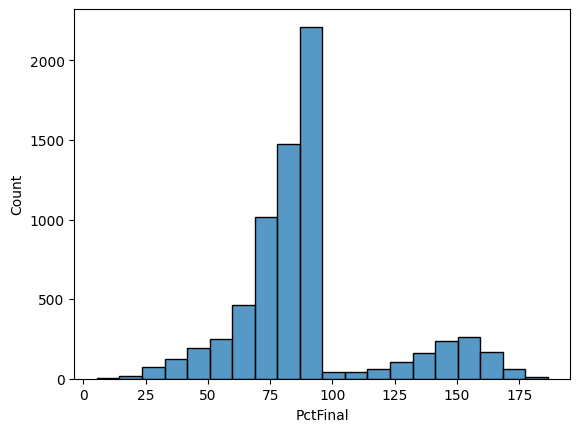

In [ ]:
# create a histogram of the PctFinal column
sns.histplot(data=new_aber, x="PctFinal", bins=20)
# show the histogram
plt.show()

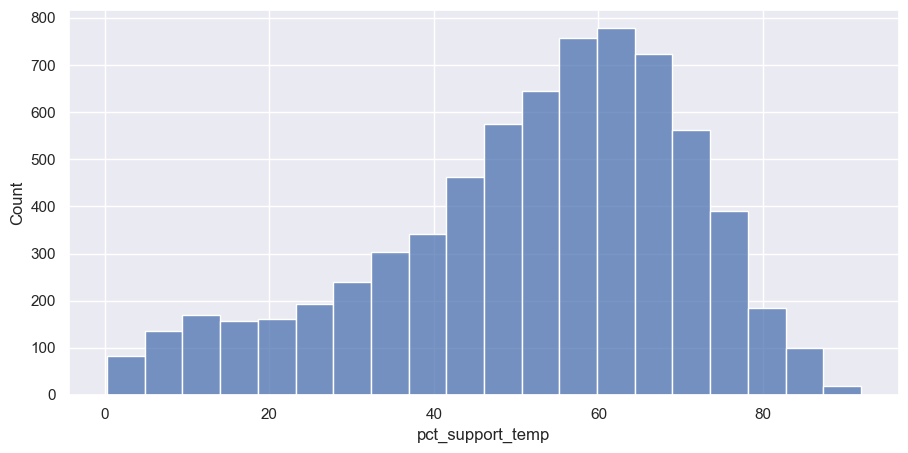

In [ ]:
# make the same graph for pct_support_temp and pctabber
sns.histplot(data=new_aber, x="pct_support_temp", bins=20)
plt.show()


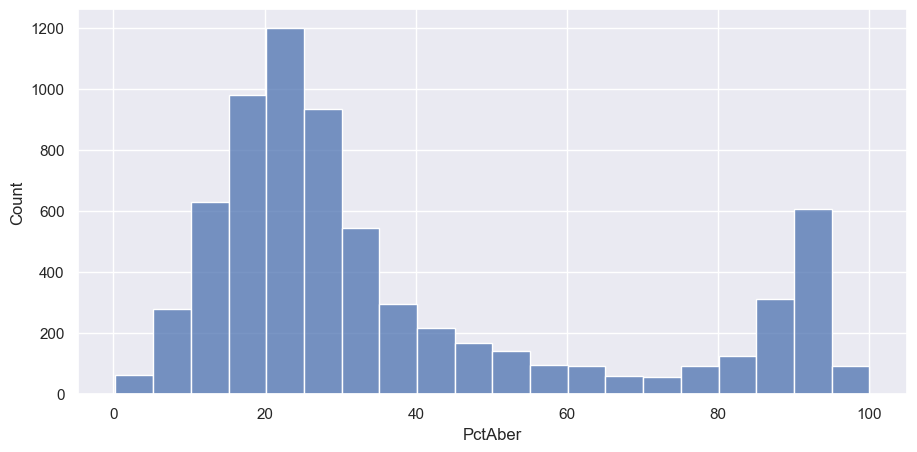

In [ ]:
# make the same graph for pctabber
sns.histplot(data=new_aber, x="PctAber", bins=20)
plt.show()


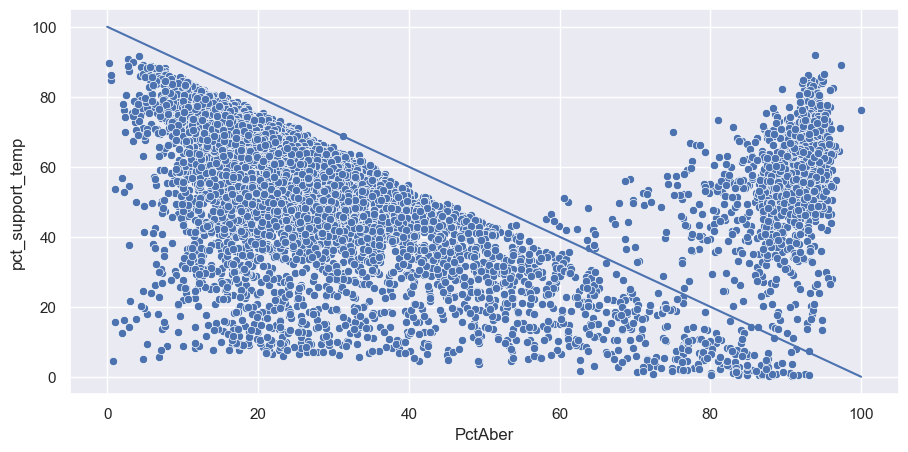

In [ ]:
# make a dot plot with pctabber on the x axis and pct_support_temp on the y axis
sns.scatterplot(data=new_aber, x="PctAber", y="pct_support_temp")
plt.plot([0, 100], [100, 0])
plt.plot([0, 0],[100, 100])
plt.show()

In [ ]:
# filter the ones where PassedAberrantFilter is less than ReadsWithPrimer
new_aber[new_aber["PassedAberrantFilter"] < new_aber["ReadsWithPrimer"]]
#new_aber["pct_support"] = (new_aber["asv_support"])/((new_aber["ReadsWithPrimer"] + abber["Aberrant_LC_reads"]))


,seq,chain,entry__mabid,entry__clonality,entry__category,pk,asv_support,total_reads,domain,plate,SMARTindex,parent,project,Chain,RawReads,ReadsWithPrimer,Ga12HC,Ga3HC,LaLC,KaLC,ReadsToFilter,PassedAberrantFilter,Aberrant_LC_reads,ReadsToOverlap,ShortInsert,MediumInserts,LongInserts,Overlapped,LengthFiltered,PctAber,TOTAL_READS,pct_support,pct_support_temp,PctFinal
79,AATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAGTT...,Light,L36/12.9,Monoclonal,1.0,177,21.0,23,"D,I,Q,M,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,I,S,C,...",TRIMMER0002_P2,86-SMARTindex,L36/12,L36,L,571113.0,135.0,0.0,0.0,6.0,129.0,134.0,134.0,43.0,134.0,77.0,35.0,22.0,112.0,33.0,31.851852,178.0,15.555556,15.555556,47.407407
88,GAAATACATCAGACCAGCATGGGCTTCAAGATGGAGTCTCATACTC...,Light,N397/19.1.1,Monoclonal,1.0,285,5596.0,5884,"D,I,V,M,T,Q,S,Q,K,F,M,S,T,S,V,G,D,R,L,S,I,I,C,...",TRIMMER0003_P3,03-SMARTindex,N397/19,N397,L,1684305.0,7978.0,0.0,0.0,2.0,7976.0,7972.0,7972.0,1690.0,7972.0,7.0,7616.0,349.0,7623.0,7481.0,21.183254,9668.0,70.142893,70.142893,91.326147
89,AGCATCAGACAGGCTGGGCAGCAAGATGGAATCACAGACCCAGGTC...,Light,N447/24.8,Monoclonal,1.0,286,3298.0,3434,"D,I,V,M,T,Q,S,P,S,S,L,A,M,S,V,G,Q,K,V,T,M,S,C,...",TRIMMER0003_P3,04-SMARTindex,N447/24,N447,L,1684305.0,5355.0,0.0,0.0,9.0,5346.0,5353.0,5353.0,1741.0,5353.0,9.0,5109.0,235.0,5118.0,5033.0,32.511671,7096.0,61.587302,61.587302,94.098973
90,AAGCATCCTCTCATCTAGTTCTCAGAGATGGAGACAGACACAATCC...,Light,N245/36.1,Monoclonal,1.0,287,7795.0,10377,"D,I,V,L,T,Q,S,P,A,S,L,A,V,S,Q,G,Q,R,A,T,I,S,C,...",TRIMMER0003_P3,05-SMARTindex,N245/36,N245,L,1684305.0,13075.0,0.0,0.0,8.0,13067.0,13066.0,13066.0,2647.0,13066.0,17.0,12254.0,795.0,12271.0,11852.0,20.244742,15722.0,59.617591,59.617591,79.862333
91,AGGACAATGGCAGAAAGTCACTCTCAGTGAGGATACACCATCAGCA...,Light,N425/45.4,Monoclonal,1.0,288,3299.0,3400,"D,I,Q,M,N,Q,S,P,S,S,L,S,A,S,L,G,D,T,I,T,I,T,C,...",TRIMMER0003_P3,06-SMARTindex,N425/45,N425,L,1684305.0,6024.0,0.0,0.0,1.0,6023.0,6020.0,6020.0,2400.0,6020.0,14.0,5682.0,324.0,5696.0,5613.0,39.840637,8424.0,54.764276,54.764276,94.604914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6898,ACTTTTGACTCACCATATCAAGTTCGCAGAATGAGGTTCTCTGCTC...,Light,N158/15.4,Monoclonal,2.0,24819,3570.0,3688,"D,I,V,M,T,Q,A,A,F,S,N,P,V,T,L,G,T,S,A,S,I,S,C,...",TRIMMER00112_P100,01-SMARTindex,N158/15,N158,L,2216900.0,8950.0,0.0,0.0,197.0,8753.0,8949.0,8949.0,7599.0,8949.0,1353.0,5193.0,2403.0,6546.0,4964.0,84.905028,17254.0,39.888268,39.888268,124.793296
6904,ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...,Light,N194/17.4,Monoclonal,2.0,24827,5923.0,6159,"D,V,V,M,T,Q,S,P,L,T,L,S,V,T,I,G,Q,T,A,S,-,I,S,...",TRIMMER00112_P100,07-SMARTindex,N194/17,N194,L,2216900.0,13427.0,0.0,0.0,29.0,13398.0,13426.0,13426.0,3427.0,13426.0,1443.0,8457.0,3526.0,9900.0,8360.0,25.523200,17459.0,44.112609,44.112609,69.635808
6929,GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...,Light,N293/73.5,Monoclonal,2.0,24855,4703.0,4771,"Q,A,V,V,T,Q,E,S,A,-,L,T,T,S,P,G,E,T,V,T,L,T,C,...",TRIMMER00112_P100,35-SMARTindex,N293/73,N293,L,2216900.0,10934.0,0.0,0.0,9295.0,1639.0,10933.0,10933.0,1451.0,10933.0,490.0,5811.0,4632.0,6301.0,5740.0,13.270532,13075.0,43.012621,43.012621,56.283153
6942,AATTAGCTAGGGACCAAAATTCAAAGACAGAATGGATTTTCAGGTG...,Light,N299/45.3,Monoclonal,2.0,24868,3345.0,3586,"Q,T,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,I,S,C,...",TRIMMER00112_P100,51-SMARTindex,N299/45,N299,L,2216900.0,7565.0,0.0,0.0,64.0,7501.0,7564.0,7564.0,2448.0,7564.0,551.0,5266.0,1747.0,5817.0,5133.0,32.359551,10267.0,44.216788,44.216788,76.576338


In [ ]:
# filter based on PctFinal > 100 and count the occurences from each plate and show the top 10
# increase the number of rows shown
pd.set_option('display.max_rows', 500)
new_aber[(new_aber["PctFinal"] > 100) & (new_aber["plate"] == "TRIMMER0046_P39")]
#print(len(new_aber[new_aber["PctFinal"] > 100].groupby("plate").count().sort_values("PctFinal", ascending=False)))

,seq,chain,entry__mabid,entry__clonality,entry__category,pk,asv_support,total_reads,domain,plate,SMARTindex,parent,project,Chain,RawReads,ReadsWithPrimer,Ga12HC,Ga3HC,LaLC,KaLC,ReadsToFilter,PassedAberrantFilter,Aberrant_LC_reads,ReadsToOverlap,ShortInsert,MediumInserts,LongInserts,Overlapped,LengthFiltered,PctAber,TOTAL_READS,pct_support,pct_support_temp,PctFinal
2966,AATCCACAGAAGCTCAGGGAAAATTTGAAGATGGTGTCCACTTCTC...,Light,K93X/1.6,Monoclonal,2.0,7426,1409.0,2118,"D,I,V,M,T,Q,S,P,A,T,L,S,V,T,P,G,D,R,V,S,L,S,C,...",TRIMMER0046_P39,02-SMARTindex,K93X/1,K93X,L,966125.0,3930.0,0.0,0.0,3.0,3927.0,3930.0,3930.0,3657.0,3930.0,6.0,3679.0,245.0,3685.0,3617.0,93.053435,7587.0,35.852417,35.852417,128.905852
2967,CTGCATCAGAAAGGCAGGGGGATCAAGATGGAATCACAGACTCAGG...,Light,K93X/1.6,Monoclonal,2.0,7427,292.0,2118,"N,I,M,M,T,Q,S,P,S,S,L,A,V,S,A,G,E,K,V,T,M,S,C,...",TRIMMER0046_P39,02-SMARTindex,K93X/1,K93X,L,966125.0,3930.0,0.0,0.0,3.0,3927.0,3930.0,3930.0,3657.0,3930.0,6.0,3679.0,245.0,3685.0,3617.0,93.053435,7587.0,7.430025,7.430025,100.483461
2969,AATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAGTT...,Light,K50/27.1,Monoclonal,2.0,7430,2795.0,2933,"D,I,Q,M,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,I,S,C,...",TRIMMER0046_P39,04-SMARTindex,K50/27,K50,L,966125.0,4718.0,0.0,0.0,4.0,4714.0,4718.0,4718.0,4453.0,4718.0,8.0,4460.0,250.0,4468.0,4416.0,94.383213,9171.0,59.241204,59.241204,153.624417
2977,AATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAGTT...,Light,K50/36.1,Monoclonal,2.0,7444,2344.0,2418,"D,I,Q,M,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,I,S,C,...",TRIMMER0046_P39,12-SMARTindex,K50/36,K50,L,966125.0,3762.0,0.0,0.0,2.0,3760.0,3762.0,3762.0,3532.0,3762.0,4.0,3577.0,181.0,3581.0,3534.0,93.886231,7294.0,62.307283,62.307283,156.193514
2980,ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...,Light,K92/24.1,Monoclonal,2.0,7447,5322.0,5646,"D,V,L,M,T,Q,T,P,L,S,L,S,V,S,L,G,D,Q,A,S,I,S,C,...",TRIMMER0046_P39,15-SMARTindex,K92/24,K92,L,966125.0,7814.0,0.0,0.0,3.0,7811.0,7814.0,7814.0,7260.0,7814.0,8.0,7359.0,447.0,7367.0,7306.0,92.910161,15074.0,68.108523,68.108523,161.018684
2983,ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...,Light,K93X/22.6,Monoclonal,2.0,7451,2991.0,3203,"D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...",TRIMMER0046_P39,18-SMARTindex,K93X/22,K93X,L,966125.0,5206.0,0.0,0.0,0.0,5206.0,5206.0,5206.0,4898.0,5206.0,4.0,4903.0,299.0,4907.0,4848.0,94.083750,10104.0,57.452939,57.452939,151.536688
2987,ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...,Light,K92/33.1,Monoclonal,2.0,7455,3716.0,4345,"D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,V,S,I,S,C,...",TRIMMER0046_P39,23-SMARTindex,K92/33,K92,L,966125.0,6510.0,0.0,0.0,8.0,6502.0,6510.0,6510.0,6121.0,6510.0,8.0,6176.0,326.0,6184.0,6127.0,94.024578,12631.0,57.081413,57.081413,151.105991
2988,ATCCTCTCTTCTAGCTCTCAGAGATGGAGACAGACACACTCCTGCT...,Light,K82/38.1,Monoclonal,2.0,7456,3173.0,4760,"D,I,V,L,T,Q,S,P,A,S,L,V,V,S,L,G,Q,R,A,T,I,S,C,...",TRIMMER0046_P39,24-SMARTindex,K82/38,K82,L,966125.0,6996.0,0.0,0.0,11.0,6985.0,6996.0,6996.0,6477.0,6996.0,22.0,6552.0,422.0,6574.0,6428.0,92.581475,13473.0,45.354488,45.354488,137.935963
2992,AATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAGTT...,Light,K52/1.1,Monoclonal,2.0,7461,1457.0,1669,"D,I,Q,M,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,I,S,C,...",TRIMMER0046_P39,29-SMARTindex,K52/1,K52,L,966125.0,3669.0,0.0,0.0,10.0,3659.0,3669.0,3669.0,3160.0,3669.0,12.0,3450.0,207.0,3462.0,3216.0,86.127010,6829.0,39.711093,39.711093,125.838103
3002,ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...,Light,K77/236.1,Monoclonal,2.0,7472,2481.0,2627,"D,I,V,M,T,Q,A,A,P,S,V,P,V,T,P,G,E,S,V,S,-,I,S,...",TRIMMER0046_P39,40-SMARTindex,K77/236,K77,L,966125.0,5173.0,0.0,0.0,8.0,5165.0,5173.0,5173.0,4767.0,5173.0,14.0,4829.0,330.0,4843.0,4737.0,92.151556,10737.0,47.960564,47.960564,140.112121


In [ ]:
# summarize the plates from the above filter
new_aber[new_aber["PctFinal"] > 100].groupby("entry__category").count()

,seq,chain,entry__mabid,entry__clonality,pk,asv_support,total_reads,domain,plate,SMARTindex,parent,project,Chain,RawReads,ReadsWithPrimer,Ga12HC,Ga3HC,LaLC,KaLC,ReadsToFilter,PassedAberrantFilter,Aberrant_LC_reads,ReadsToOverlap,ShortInsert,MediumInserts,LongInserts,Overlapped,LengthFiltered,PctAber,TOTAL_READS,pct_support,pct_support_temp,PctFinal
entry__category,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1.0,125,125,125,125,125,125,125,125,125,125,125,125,125,125,125,125,125,125,125,125,125,125,125,125,125,125,125,125,125,124,125,125,125
2.0,778,778,778,778,778,778,778,778,778,778,778,778,778,778,778,778,778,778,778,778,778,778,778,778,778,778,778,778,778,771,778,778,778
3.0,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,237,238,238,238


In [ ]:
df_lh_bu = new_aber #TODO these are pretty much the same thing just for some reason use one the the other

In [ ]:
# Before change (chemical)
# N1-N377
# All D, all K, L1-L93
# After change (electro)
# N378-present
# L94-present

def fusion_type(df_lh_bu, mabid_column="entry__mabid"):
    # split on the "/" and strip remove all non numeric characters from the entry__mabid column
    df_lh_bu["entry__mabid__project_num"] = df_lh_bu[mabid_column].str.split("/").str[0].str.replace("[^0-9]", "")
    # split on the "/" and strip remove all non alphabet characters from the entry__mabid column first portion
    df_lh_bu["entry__mabid__project_alpha"] = df_lh_bu[mabid_column].str.split("/").str[0].str.replace("[^a-zA-Z]", "")
    # fill the na and "" from the project number column with 0 and same with empty strings
    df_lh_bu["entry__mabid__project_num"] = df_lh_bu["entry__mabid__project_num"].fillna(0).replace("",0)
    # create a new column called fusion_type and where the project number is less then 378 and project alpha is N, set it to chemical
    df_lh_bu["fusion_type"] = np.where((df_lh_bu["entry__mabid__project_num"].astype(int) < 378) & (df_lh_bu["entry__mabid__project_alpha"] == "N"), "chemical", "electro")
    # set fusion type to chemical if the project alpha is D or K
    df_lh_bu["fusion_type"] = np.where((df_lh_bu["entry__mabid__project_alpha"] == "D") | (df_lh_bu["entry__mabid__project_alpha"] == "K"), "chemical", df_lh_bu["fusion_type"])
    # set the fustion type to chemical if the project number is less then 93 and the project alpha is L
    df_lh_bu["fusion_type"] = np.where((df_lh_bu["entry__mabid__project_num"].astype(int) < 93) & (df_lh_bu["entry__mabid__project_alpha"] == "L"), "chemical", df_lh_bu["fusion_type"])

    return df_lh_bu

<ipython-input-236-43f89194cf5d>:11: FutureWarning:

The default value of regex will change from True to False in a future version.

<ipython-input-236-43f89194cf5d>:13: FutureWarning:

The default value of regex will change from True to False in a future version.



In [ ]:
df_lh_bu = fusion_type(df_lh_bu, mabid_column="entry__mabid")

,seq,chain,entry__mabid,entry__clonality,entry__category,pk,asv_support,total_reads,domain,plate,SMARTindex,parent,project,Chain,RawReads,ReadsWithPrimer,Ga12HC,Ga3HC,LaLC,KaLC,ReadsToFilter,PassedAberrantFilter,Aberrant_LC_reads,ReadsToOverlap,ShortInsert,MediumInserts,LongInserts,Overlapped,LengthFiltered,PctAber,TOTAL_READS,pct_support,pct_support_temp,PctFinal,entry__mabid__project_num,entry__mabid__project_alpha,fusion_type
0,GACTGAGATGGAAAACAAAATGGATTTTCAGATGCAGATTATCAGC...,Light,L130/1.1,Monoclonal,1.0,90,4228.0,4353,"E,I,V,L,T,Q,S,P,T,T,L,A,A,S,P,G,E,K,I,T,I,T,C,...",TRIMMER0002_P2,02-SMARTindex,L130/1,L130,L,571113.0,6043.0,0.0,0.0,16.0,6027.0,6043.0,6043.0,1182.0,6043.0,362.0,5452.0,229.0,5814.0,5401.0,19.559821,NaN,69.965249,69.965249,89.525070,130,L,electro
1,AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...,Light,L80/21.1,Monoclonal,1.0,91,3518.0,3631,"Q,I,V,L,T,Q,S,P,A,I,M,S,A,F,P,G,E,R,V,T,M,T,C,...",TRIMMER0002_P2,03-SMARTindex,L80/21,L80,L,571113.0,5064.0,0.0,0.0,12.0,5052.0,5064.0,5064.0,876.0,5064.0,321.0,4491.0,252.0,4812.0,4416.0,17.298578,5940.0,69.470774,69.470774,86.769352,80,L,chemical
2,GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...,Light,L106/83.1,Monoclonal,1.0,93,3153.0,3166,"Q,A,V,V,T,Q,E,S,A,-,L,T,T,S,P,G,E,T,V,T,L,T,C,...",TRIMMER0002_P2,04-SMARTindex,L106/83,L106,L,571113.0,4334.0,0.0,0.0,3562.0,772.0,4334.0,4334.0,637.0,4334.0,304.0,3787.0,243.0,4091.0,3763.0,14.697739,4971.0,72.750346,72.750346,87.448085,106,L,electro
3,ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...,Light,N486/76.1,Monoclonal,1.0,94,1804.0,1855,"D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...",TRIMMER0002_P2,05-SMARTindex,N486/76,N486,L,571113.0,2462.0,0.0,0.0,17.0,2445.0,2462.0,2462.0,2219.0,2462.0,195.0,2137.0,130.0,2332.0,2115.0,90.129976,4681.0,73.273761,73.273761,163.403737,486,N,electro
4,AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...,Light,N123/48.1,Monoclonal,1.0,95,25.0,42,"Q,L,M,L,T,Q,S,S,S,-,A,S,F,S,L,G,A,S,A,K,L,T,C,...",TRIMMER0002_P2,06-SMARTindex,N123/48,N123,L,571113.0,1197.0,0.0,0.0,59.0,1138.0,1197.0,1197.0,973.0,1197.0,217.0,922.0,58.0,1139.0,892.0,81.286550,2170.0,2.088555,2.088555,83.375104,123,N,chemical
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6977,ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...,Light,N238/24.5,Monoclonal,2.0,24906,2767.0,2974,"D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...",TRIMMER00112_P100,92-SMARTindex,N238/24,N238,L,2216900.0,8008.0,0.0,0.0,75.0,7933.0,8008.0,8008.0,3183.0,8008.0,657.0,5082.0,2269.0,5739.0,4999.0,39.747752,11191.0,34.552947,34.552947,74.300699,238,N,chemical
6978,GACTGAGATGGAAAACAAAATGGATTTTCAGATGCAGATTATCAGC...,Light,N268/33.5,Monoclonal,2.0,24907,3833.0,4127,"E,I,V,L,T,Q,S,P,V,T,M,A,A,S,P,G,E,K,I,T,I,T,C,...",TRIMMER00112_P100,93-SMARTindex,N268/33,N268,L,2216900.0,9317.0,0.0,0.0,47.0,9270.0,9317.0,9317.0,2653.0,9317.0,1275.0,6088.0,1954.0,7363.0,5852.0,28.474831,11970.0,41.139852,41.139852,69.614683,268,N,chemical
6979,AGACAGGCAGTGGGAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...,Light,N237/24.3,Monoclonal,2.0,24908,860.0,899,"D,I,V,M,S,Q,S,P,P,S,L,A,V,S,A,G,E,K,V,T,M,S,C,...",TRIMMER00112_P100,94-SMARTindex,N237/24,N237,L,2216900.0,1662.0,0.0,0.0,31.0,1631.0,1662.0,1662.0,227.0,1662.0,159.0,1049.0,454.0,1208.0,1033.0,13.658243,1889.0,51.744886,51.744886,65.403129,237,N,chemical
6980,ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...,Light,L87/37.5,Monoclonal,2.0,24909,5857.0,6491,"D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...",TRIMMER00112_P100,95-SMARTindex,L87/37,L87,L,2216900.0,13244.0,0.0,0.0,31.0,13213.0,13244.0,13244.0,2721.0,13244.0,1358.0,8228.0,3658.0,9586.0,8090.0,20.545153,15965.0,44.223799,44.223799,64.768952,87,L,chemical


## Make some graphs for the paper

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


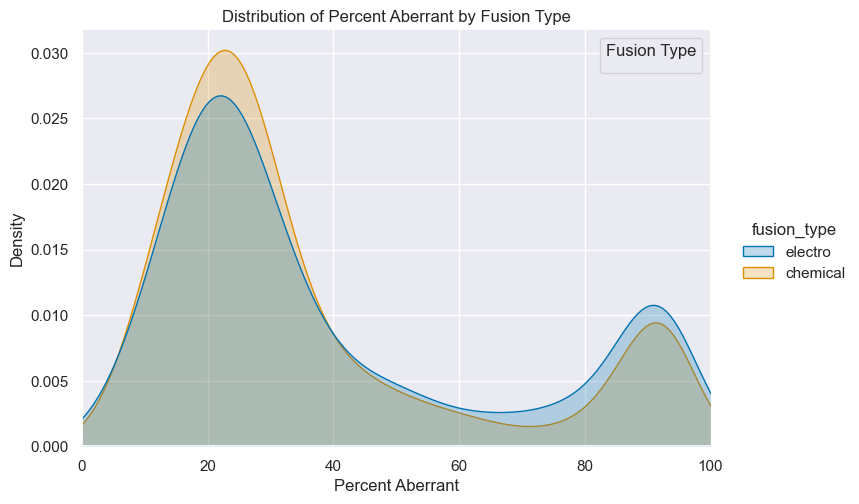

In [ ]:
# graph the distribution of the percent abberant column split by fusion type
sns.displot(df_lh_bu, x="PctAber", hue="fusion_type", kind="kde", fill=True, palette="colorblind", common_norm=False, aspect=1.5, height=5)
plt.xlim(0, 100)
# change the hue legend title
plt.legend(title="Fusion Type")
plt.xlabel("Percent Aberrant")
plt.ylabel("Density")
plt.title("Distribution of Percent Aberrant by Fusion Type")
plt.show()

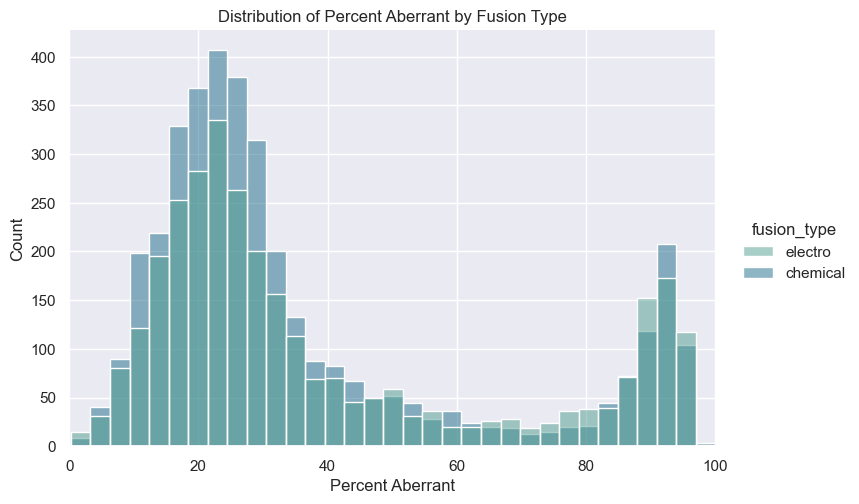

In [ ]:
# graph the histogram of the percent abberant column split by fusion type
sns.displot(df_lh_bu, x="PctAber", hue="fusion_type", kind="hist", fill=True, palette="crest", common_norm=False, aspect=1.5, height=5)
plt.xlim(0, 100)
plt.xlabel("Percent Aberrant")
plt.ylabel("Count")
plt.title("Distribution of Percent Aberrant by Fusion Type")
plt.show()

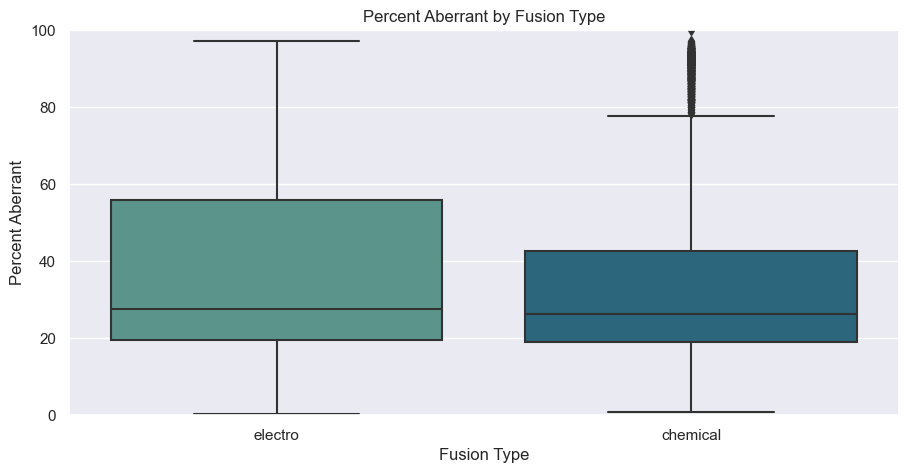

In [ ]:
# plot a box and whisker plot for each fusion type and map the statistical significance as * for p < 0.05 and ** for p < 0.01
sns.boxplot(data=df_lh_bu, x="fusion_type", y="PctAber", palette="crest")
plt.ylim(0, 100)
plt.xlabel("Fusion Type")
plt.ylabel("Percent Aberrant")
plt.title("Percent Aberrant by Fusion Type")
plt.show()


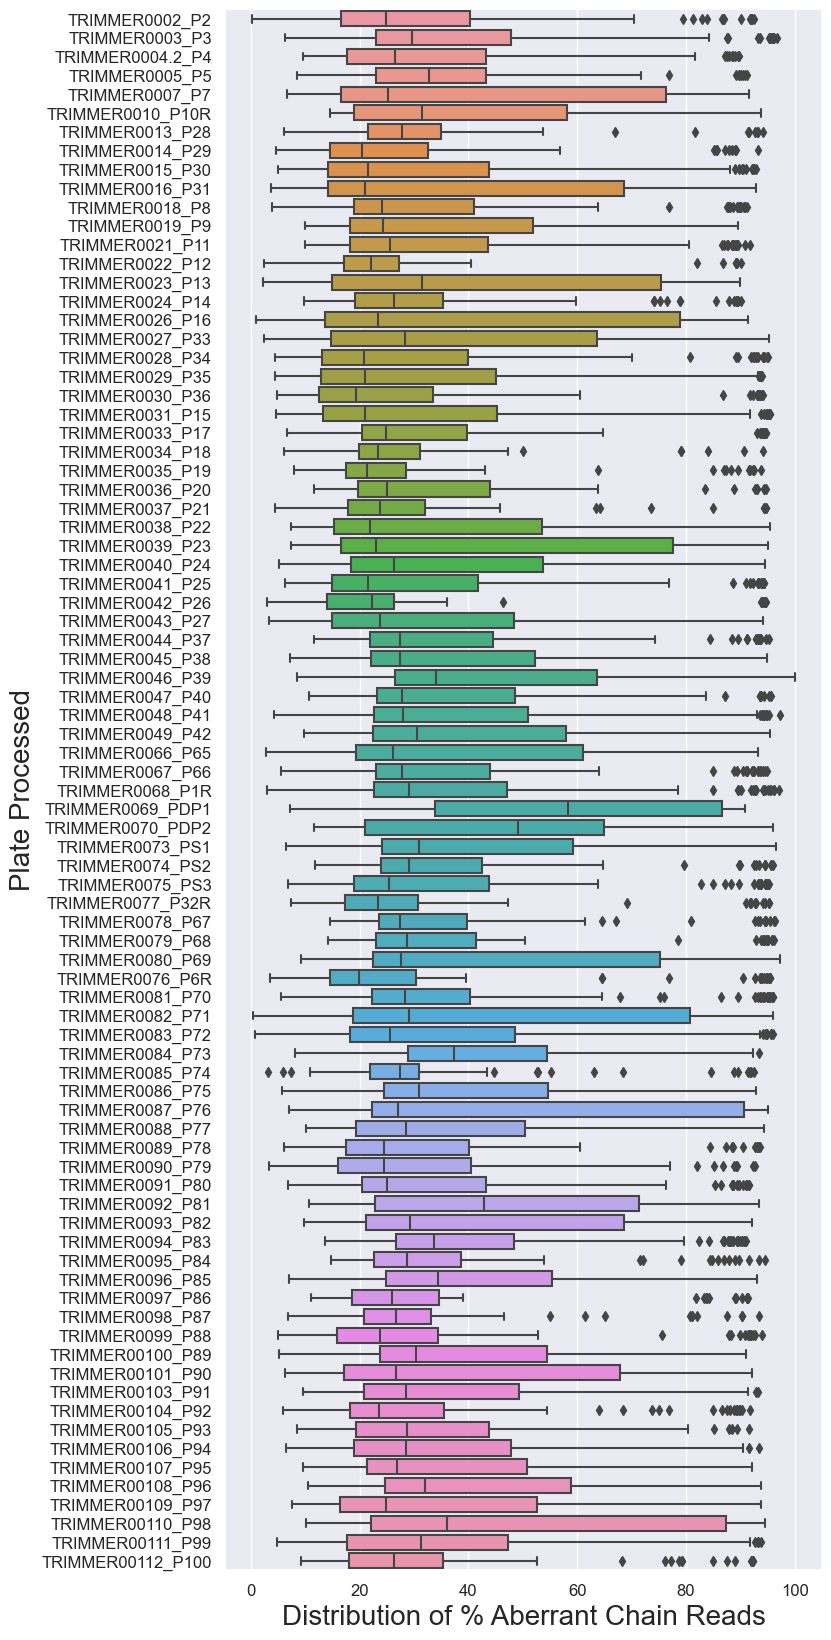

In [ ]:


new_aber = df_lh_bu
sns.set(rc={'figure.figsize':(7.7,20.27)})
ax = sns.boxplot(data=new_aber, x="PctAber", y="plate",)
ax.set_xlabel("Distribution of % Aberrant Chain Reads",fontsize=20)
ax.set_ylabel("Plate Processed",fontsize=20)
ax.tick_params(labelsize=12)
plt.show()


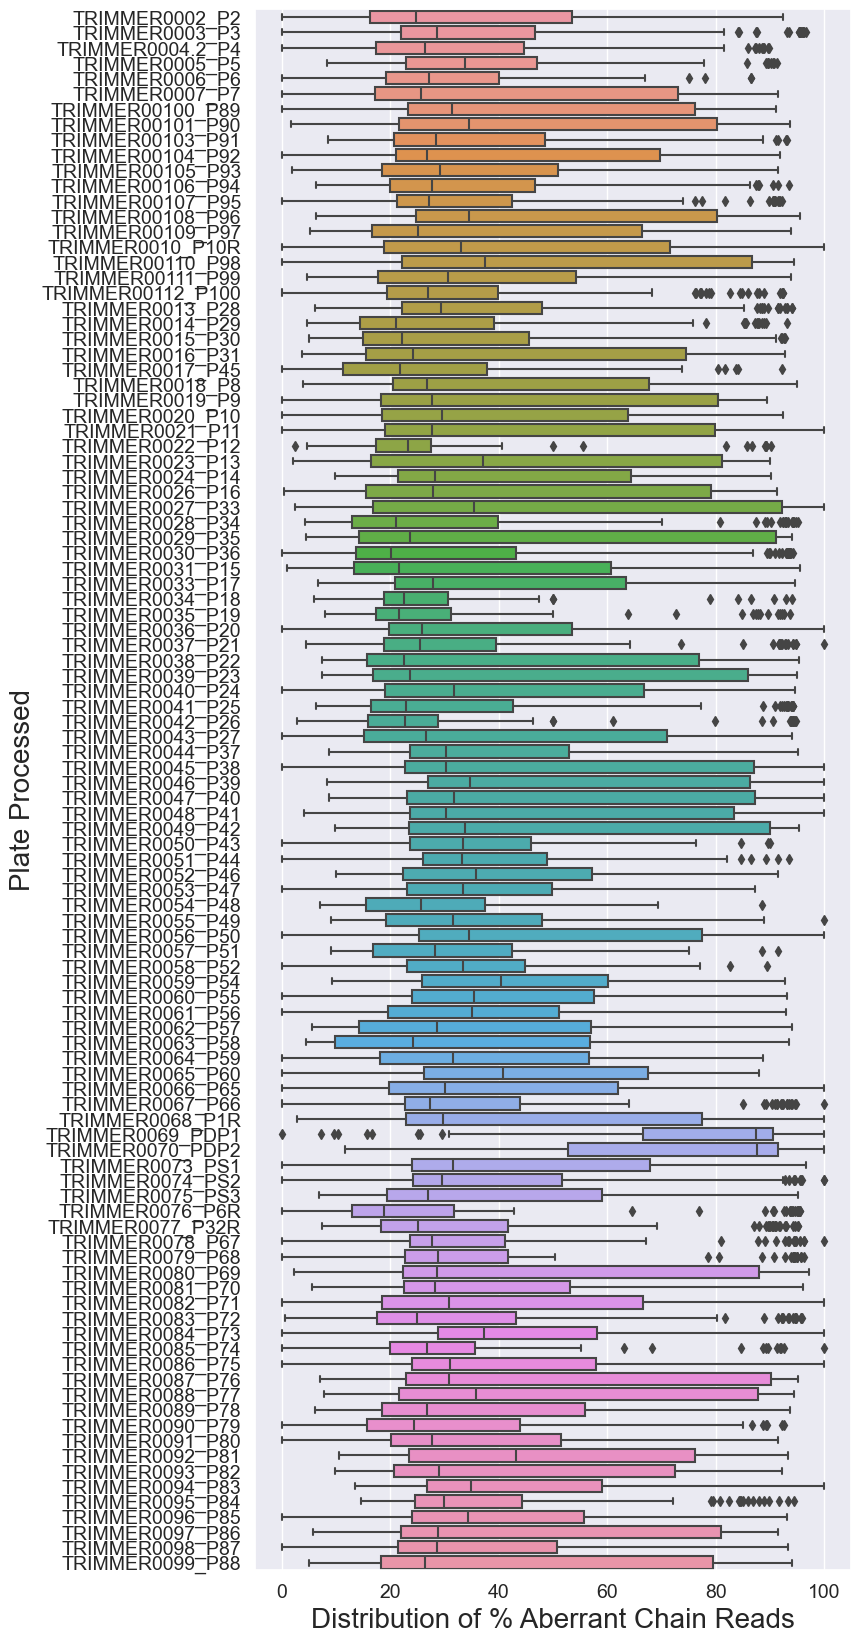

In [ ]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(7.7,20.27)})
ax = sns.boxplot(data=abber[abber["Chain"]=="L"], x="PctAber", y="plate",)
ax.set_xlabel("Distribution of % Aberrant Chain Reads",fontsize=20)
ax.set_ylabel("Plate Processed",fontsize=20)
ax.tick_params(labelsize=14)
plt.show()


In [ ]:
# this is the same as the bradbur table except for this is only LC counts
aber_parent = new_aber.groupby(["parent","fusion_type"]).agg({"PctAber": ["count", "mean"]}).reset_index()#.droplevel(0, axis=1)
aber_parent.columns = aber_parent.columns.droplevel(0)
aber_parent.columns = ["project", "fusion_type", "count", "mean"]
aber_parent

,project,fusion_type,count,mean
0,1D8,chemical,3,28.987620
1,1F1,electro,4,46.806008
2,62-3G1,electro,3,0.415712
3,8G10,electro,1,35.398230
4,A12/18,electro,3,38.035359
...,...,...,...,...
2150,N9C/24,electro,2,19.404690
2151,UNC65,electro,2,87.927517
2152,n152b/11,electro,1,16.633019
2153,n194/17,electro,1,17.505928


In [ ]:
# compare the aber-parent project column unique values to the bradbury entry__pk column unique values using sets
#print(len(set(aber_parent["project"].unique()) - set(bradbur["entry__pk"].unique())))
#print(set(aber_parent["project"].unique()) - set(bradbur["entry__pk"].unique()))

228
{'N414/50', 'N139/27', 'N460/96', 'N45B/46', 'N231B/30', 'N265/18', 'N383/18', 'N55/53', 'N230/17', 'N198/20', 'N429/47', 'L69/45', 'L125/118', 'N463/10', 'N187/7', 'N481/97', 'N231/48', 'N194/13', 'L116/86', 'N402/61', 'N106/48', 'K97/20', 'N435/93', 'N132/15', 'L106/73', 'N165/58', 'N23/31', 'N292/15', 'L107/56', 'N361A/88', 'N481/49', 'N267/5', 'N491/22', 'N291/30', 'N142/17', 'N351/42', 'EMPTY', 'N363/95', 'N285/20', 'N423/23', 'L129/55', 'N267/52', 'K92/33', 'N383/77', 'N300/6', 'L49/20', 'L14/12', 'N382/22', 'N39B/22', 'N383A/24', 'K68/66', 'N387/20', 'N400/28', 'N485/20', 'D4/194', 'N335/19', 'K78/11', 'N450/84', 'N491/13', 'N183/24', 'L126/49', 'L118/65', 'N152B/11', 'N177A/15', 'D4/133', 'N271/28', 'N481/113', 'N458/42', 'L52/29', 'N157/20', 'N451/33', 'N101/23', 'N121/32', 'N270/45', 'N108/27', 'N276/30', 'N430/20', 'N485/87', 'N138A/5', 'N26/10', 'N56/43', 'N277/17', 'N154/37', 'N230/14', '1D8', 'N267/32', 'N466/85', 'N373/71', 'K56/27', 'N428/50', 'L124/81', 'L95A/44', 

In [ ]:
#print(len(set(aber_parent["project"].unique()) - set(bradbur["entry__pk"].unique())))
#print(set(bradbur["entry__pk"].unique()) - set(aber_parent["project"].unique()))

228
{'N147A/34', 'N361/60', 'N97A/30', 'N486/40'}


In [ ]:
df_lh_bu

,seq,chain,entry__mabid,entry__clonality,entry__category,pk,asv_support,total_reads,domain,plate,SMARTindex,parent,project,Chain,RawReads,ReadsWithPrimer,Ga12HC,Ga3HC,LaLC,KaLC,ReadsToFilter,PassedAberrantFilter,Aberrant_LC_reads,ReadsToOverlap,ShortInsert,MediumInserts,LongInserts,Overlapped,LengthFiltered,PctAber,TOTAL_READS,pct_support,pct_support_temp,PctFinal,entry__mabid__project_num,entry__mabid__project_alpha,fusion_type
0,GACTGAGATGGAAAACAAAATGGATTTTCAGATGCAGATTATCAGC...,Light,L130/1.1,Monoclonal,1.0,90,4228.0,4353,"E,I,V,L,T,Q,S,P,T,T,L,A,A,S,P,G,E,K,I,T,I,T,C,...",TRIMMER0002_P2,02-SMARTindex,L130/1,L130,L,571113.0,6043.0,0.0,0.0,16.0,6027.0,6043.0,6043.0,1182.0,6043.0,362.0,5452.0,229.0,5814.0,5401.0,19.559821,NaN,69.965249,69.965249,89.525070,130,L,electro
1,AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...,Light,L80/21.1,Monoclonal,1.0,91,3518.0,3631,"Q,I,V,L,T,Q,S,P,A,I,M,S,A,F,P,G,E,R,V,T,M,T,C,...",TRIMMER0002_P2,03-SMARTindex,L80/21,L80,L,571113.0,5064.0,0.0,0.0,12.0,5052.0,5064.0,5064.0,876.0,5064.0,321.0,4491.0,252.0,4812.0,4416.0,17.298578,5940.0,69.470774,69.470774,86.769352,80,L,chemical
2,GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...,Light,L106/83.1,Monoclonal,1.0,93,3153.0,3166,"Q,A,V,V,T,Q,E,S,A,-,L,T,T,S,P,G,E,T,V,T,L,T,C,...",TRIMMER0002_P2,04-SMARTindex,L106/83,L106,L,571113.0,4334.0,0.0,0.0,3562.0,772.0,4334.0,4334.0,637.0,4334.0,304.0,3787.0,243.0,4091.0,3763.0,14.697739,4971.0,72.750346,72.750346,87.448085,106,L,electro
3,ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...,Light,N486/76.1,Monoclonal,1.0,94,1804.0,1855,"D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...",TRIMMER0002_P2,05-SMARTindex,N486/76,N486,L,571113.0,2462.0,0.0,0.0,17.0,2445.0,2462.0,2462.0,2219.0,2462.0,195.0,2137.0,130.0,2332.0,2115.0,90.129976,4681.0,73.273761,73.273761,163.403737,486,N,electro
4,AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...,Light,N123/48.1,Monoclonal,1.0,95,25.0,42,"Q,L,M,L,T,Q,S,S,S,-,A,S,F,S,L,G,A,S,A,K,L,T,C,...",TRIMMER0002_P2,06-SMARTindex,N123/48,N123,L,571113.0,1197.0,0.0,0.0,59.0,1138.0,1197.0,1197.0,973.0,1197.0,217.0,922.0,58.0,1139.0,892.0,81.286550,2170.0,2.088555,2.088555,83.375104,123,N,chemical
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6977,ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...,Light,N238/24.5,Monoclonal,2.0,24906,2767.0,2974,"D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...",TRIMMER00112_P100,92-SMARTindex,N238/24,N238,L,2216900.0,8008.0,0.0,0.0,75.0,7933.0,8008.0,8008.0,3183.0,8008.0,657.0,5082.0,2269.0,5739.0,4999.0,39.747752,11191.0,34.552947,34.552947,74.300699,238,N,chemical
6978,GACTGAGATGGAAAACAAAATGGATTTTCAGATGCAGATTATCAGC...,Light,N268/33.5,Monoclonal,2.0,24907,3833.0,4127,"E,I,V,L,T,Q,S,P,V,T,M,A,A,S,P,G,E,K,I,T,I,T,C,...",TRIMMER00112_P100,93-SMARTindex,N268/33,N268,L,2216900.0,9317.0,0.0,0.0,47.0,9270.0,9317.0,9317.0,2653.0,9317.0,1275.0,6088.0,1954.0,7363.0,5852.0,28.474831,11970.0,41.139852,41.139852,69.614683,268,N,chemical
6979,AGACAGGCAGTGGGAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...,Light,N237/24.3,Monoclonal,2.0,24908,860.0,899,"D,I,V,M,S,Q,S,P,P,S,L,A,V,S,A,G,E,K,V,T,M,S,C,...",TRIMMER00112_P100,94-SMARTindex,N237/24,N237,L,2216900.0,1662.0,0.0,0.0,31.0,1631.0,1662.0,1662.0,227.0,1662.0,159.0,1049.0,454.0,1208.0,1033.0,13.658243,1889.0,51.744886,51.744886,65.403129,237,N,chemical
6980,ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...,Light,L87/37.5,Monoclonal,2.0,24909,5857.0,6491,"D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...",TRIMMER00112_P100,95-SMARTindex,L87/37,L87,L,2216900.0,13244.0,0.0,0.0,31.0,13213.0,13244.0,13244.0,2721.0,13244.0,1358.0,8228.0,3658.0,9586.0,8090.0,20.545153,15965.0,44.223799,44.223799,64.768952,87,L,chemical


In [ ]:
new_aber

,seq,chain,entry__mabid,entry__clonality,entry__category,pk,asv_support,total_reads,domain,plate,SMARTindex,parent,project,Chain,RawReads,ReadsWithPrimer,Ga12HC,Ga3HC,LaLC,KaLC,ReadsToFilter,PassedAberrantFilter,Aberrant_LC_reads,ReadsToOverlap,ShortInsert,MediumInserts,LongInserts,Overlapped,LengthFiltered,PctAber,TOTAL_READS,pct_support,pct_support_temp,PctFinal,entry__mabid__project_num,entry__mabid__project_alpha,fusion_type
0,GACTGAGATGGAAAACAAAATGGATTTTCAGATGCAGATTATCAGC...,Light,L130/1.1,Monoclonal,1.0,90,4228.0,4353,"E,I,V,L,T,Q,S,P,T,T,L,A,A,S,P,G,E,K,I,T,I,T,C,...",TRIMMER0002_P2,02-SMARTindex,L130/1,L130,L,571113.0,6043.0,0.0,0.0,16.0,6027.0,6043.0,6043.0,1182.0,6043.0,362.0,5452.0,229.0,5814.0,5401.0,19.559821,NaN,69.965249,69.965249,89.525070,130,L,electro
1,AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...,Light,L80/21.1,Monoclonal,1.0,91,3518.0,3631,"Q,I,V,L,T,Q,S,P,A,I,M,S,A,F,P,G,E,R,V,T,M,T,C,...",TRIMMER0002_P2,03-SMARTindex,L80/21,L80,L,571113.0,5064.0,0.0,0.0,12.0,5052.0,5064.0,5064.0,876.0,5064.0,321.0,4491.0,252.0,4812.0,4416.0,17.298578,5940.0,69.470774,69.470774,86.769352,80,L,chemical
2,GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...,Light,L106/83.1,Monoclonal,1.0,93,3153.0,3166,"Q,A,V,V,T,Q,E,S,A,-,L,T,T,S,P,G,E,T,V,T,L,T,C,...",TRIMMER0002_P2,04-SMARTindex,L106/83,L106,L,571113.0,4334.0,0.0,0.0,3562.0,772.0,4334.0,4334.0,637.0,4334.0,304.0,3787.0,243.0,4091.0,3763.0,14.697739,4971.0,72.750346,72.750346,87.448085,106,L,electro
3,ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...,Light,N486/76.1,Monoclonal,1.0,94,1804.0,1855,"D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...",TRIMMER0002_P2,05-SMARTindex,N486/76,N486,L,571113.0,2462.0,0.0,0.0,17.0,2445.0,2462.0,2462.0,2219.0,2462.0,195.0,2137.0,130.0,2332.0,2115.0,90.129976,4681.0,73.273761,73.273761,163.403737,486,N,electro
4,AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...,Light,N123/48.1,Monoclonal,1.0,95,25.0,42,"Q,L,M,L,T,Q,S,S,S,-,A,S,F,S,L,G,A,S,A,K,L,T,C,...",TRIMMER0002_P2,06-SMARTindex,N123/48,N123,L,571113.0,1197.0,0.0,0.0,59.0,1138.0,1197.0,1197.0,973.0,1197.0,217.0,922.0,58.0,1139.0,892.0,81.286550,2170.0,2.088555,2.088555,83.375104,123,N,chemical
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6977,ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...,Light,N238/24.5,Monoclonal,2.0,24906,2767.0,2974,"D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...",TRIMMER00112_P100,92-SMARTindex,N238/24,N238,L,2216900.0,8008.0,0.0,0.0,75.0,7933.0,8008.0,8008.0,3183.0,8008.0,657.0,5082.0,2269.0,5739.0,4999.0,39.747752,11191.0,34.552947,34.552947,74.300699,238,N,chemical
6978,GACTGAGATGGAAAACAAAATGGATTTTCAGATGCAGATTATCAGC...,Light,N268/33.5,Monoclonal,2.0,24907,3833.0,4127,"E,I,V,L,T,Q,S,P,V,T,M,A,A,S,P,G,E,K,I,T,I,T,C,...",TRIMMER00112_P100,93-SMARTindex,N268/33,N268,L,2216900.0,9317.0,0.0,0.0,47.0,9270.0,9317.0,9317.0,2653.0,9317.0,1275.0,6088.0,1954.0,7363.0,5852.0,28.474831,11970.0,41.139852,41.139852,69.614683,268,N,chemical
6979,AGACAGGCAGTGGGAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...,Light,N237/24.3,Monoclonal,2.0,24908,860.0,899,"D,I,V,M,S,Q,S,P,P,S,L,A,V,S,A,G,E,K,V,T,M,S,C,...",TRIMMER00112_P100,94-SMARTindex,N237/24,N237,L,2216900.0,1662.0,0.0,0.0,31.0,1631.0,1662.0,1662.0,227.0,1662.0,159.0,1049.0,454.0,1208.0,1033.0,13.658243,1889.0,51.744886,51.744886,65.403129,237,N,chemical
6980,ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...,Light,L87/37.5,Monoclonal,2.0,24909,5857.0,6491,"D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...",TRIMMER00112_P100,95-SMARTindex,L87/37,L87,L,2216900.0,13244.0,0.0,0.0,31.0,13213.0,13244.0,13244.0,2721.0,13244.0,1358.0,8228.0,3658.0,9586.0,8090.0,20.545153,15965.0,44.223799,44.223799,64.768952,87,L,chemical


In [ ]:
aber_project = new_aber.groupby(["project","fusion_type"]).agg({"PctAber": ["count", "mean"]}).reset_index()#.droplevel(0, axis=1)
aber_project.columns = aber_project.columns.droplevel(0)
aber_project.columns = ["project", "fusion_type", "count", "mean"]
aber_project

,project,fusion_type,count,mean
0,1D8.1,chemical,1,32.976946
1,1D8.4,chemical,1,31.867306
2,1D8.5,chemical,1,22.118609
3,1F1.1.1.15,electro,1,51.144214
4,1F1.1.1.18,electro,2,49.278846
...,...,...,...,...
692,N9C,electro,3,21.411036
693,UNC65.56.18.11,electro,2,87.927517
694,n152b,electro,1,16.633019
695,n194,electro,1,17.505928


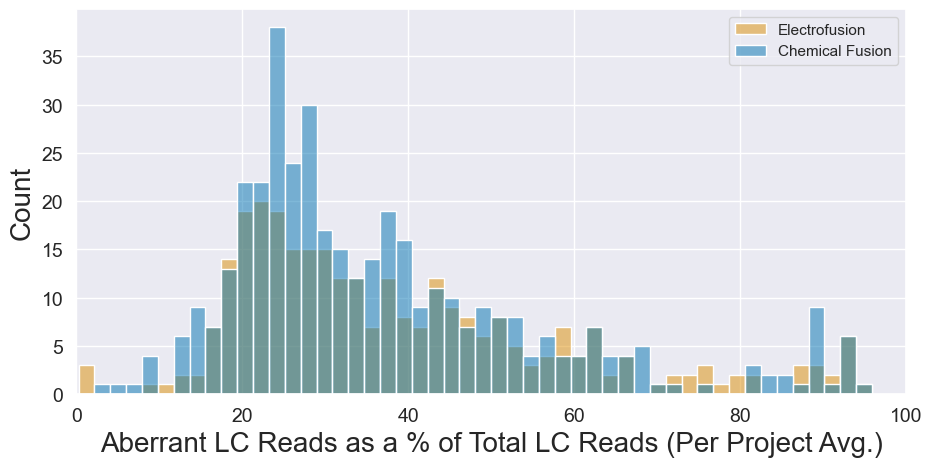

In [ ]:
# createa distribution plot of the aber_parent based on the mean
ax = sns.histplot(
    data=aber_project,
    x="mean",
    hue="fusion_type",
    bins=50,
    palette="colorblind",
)
# set the hue legend title
# set the hue legend colors
ax.legend(title=None, loc='upper right', labels=['Electrofusion', 'Chemical Fusion'])
sns.set(rc={'figure.figsize':(10.7,5)})
# add padding to the x axis
plt.xlim(0, 100)
#increase and x and y tick size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

ax.axes.set_xlabel("Aberrant LC Reads as a % of Total LC Reads (Per Project Avg.)",fontsize=20)
ax.axes.set_ylabel("Count",fontsize=20)
# output as a png
plt.savefig("jupyter/paper_figures/4b.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
# generate a text description for the figure above
print("The average % aberrant LC expression is " + str(round(aber_project["mean"].mean(), 2)) + " with a standard deviation of " + str(round(aber_project["mean"].std(), 2)) + " and a median of " + str(round(aber_project["mean"].median(), 2)) + ".")


The average % aberrant LC expression is 37.95 with a standard deviation of 19.56 and a median of 32.43.


In [ ]:
# perform a mann whitney u test between the percent abberant column split by fusion type and pretty print the results as text
mwresult = stats.mannwhitneyu(aber_project[aber_project["fusion_type"]=="chemical"]["mean"], aber_project[aber_project["fusion_type"]=="electro"]["mean"])
print("The Mann-Whitney U test between the chemical and electrofusion groups at the project level produced a p-value of " + str(round(mwresult[1], 3)) + ".")
print(mwresult)

The Mann-Whitney U test between the chemical and electrofusion groups at the project level produced a p-value of 0.149.
MannwhitneyuResult(statistic=56713.0, pvalue=0.14895349882403008)


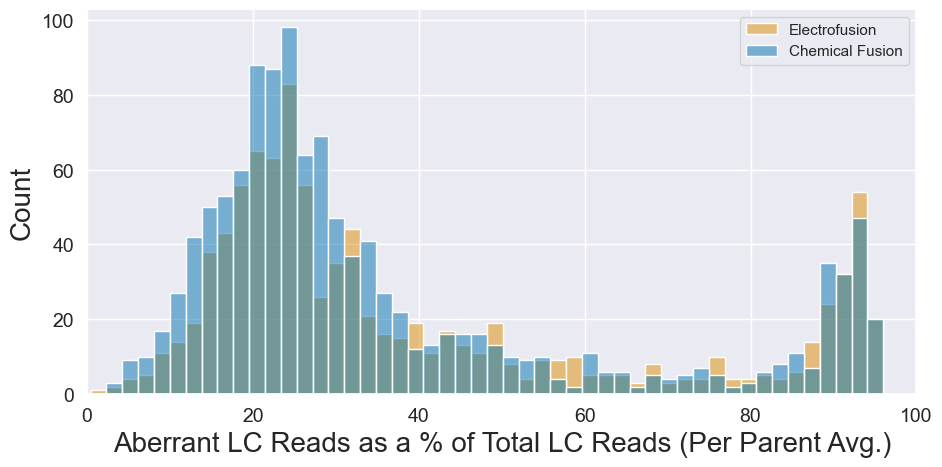

In [ ]:
ax = sns.histplot(
    data=aber_parent,
    x="mean",
    hue="fusion_type",
    bins=50,
    palette="colorblind",
)
# set the hue legend title
# set the hue legend colors
ax.legend(title=None, loc='upper right', labels=['Electrofusion', 'Chemical Fusion'])
sns.set(rc={'figure.figsize':(10.7,5)})
# add padding to the x axis
plt.xlim(0, 100)
#increase and x and y tick size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


ax.axes.set_xlabel("Aberrant LC Reads as a % of Total LC Reads (Per Parent Avg.)",fontsize=20)
ax.axes.set_ylabel("Count",fontsize=20)
# output as a png
plt.savefig("jupyter/paper_figures/4a.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
# generate different colors for the figure above
# statistical test per parent as well (bradbury big difference between rat and mouse)
# all rat ones were from one lab and mouse was from many labs
# bradbury only obvious from supplementary data

# generate a text description for the summary numbers of the figure above
print("The average % aberrant LC expression is " + str(round(aber_project["mean"].mean(), 2)) + " with a standard deviation of " + str(round(aber_project["mean"].std(), 2)) + " and a median of " + str(round(aber_project["mean"].median(), 2)) + ".")


# perform a mann whitney u test between the percent abberant column split by fusion type and pretty print the results as text
mwresult = stats.mannwhitneyu(aber_parent[aber_parent["fusion_type"]=="chemical"]["mean"], aber_parent[aber_parent["fusion_type"]=="electro"]["mean"])
print("The Mann-Whitney U test between the chemical and electrofusion groups at the parent level produced a p-value of " + str(round(mwresult[1], 5)) + ".")
print(mwresult)


The average % aberrant LC expression is 37.95 with a standard deviation of 19.56 and a median of 32.43.
The Mann-Whitney U test between the chemical and electrofusion groups at the parent level produced a p-value of 0.00188.
MannwhitneyuResult(statistic=532109.0, pvalue=0.0018787268353177957)


In [ ]:
# generate the summary text for the new_aber dataframe for the mann whitney u test
print("The average % aberrant LC expression is " + str(round(new_aber["PctAber"].mean(), 2)) + " with a standard deviation of " + str(round(new_aber["PctAber"].std(), 2)) + " and a median of " + str(round(new_aber["PctAber"].median(), 2)) + ".")
# perform a mann whitney u test between the percent abberant column split by fusion type and pretty print the results as text
mwresult = stats.mannwhitneyu(new_aber[new_aber["fusion_type"]=="chemical"]["PctAber"], new_aber[new_aber["fusion_type"]=="electro"]["PctAber"])
print("The Mann-Whitney U test between the chemical and electrofusion groups at the per sequence level is " + str(round(mwresult[1], 5)) + ".")
print(mwresult)


The average % aberrant LC expression is 37.79 with a standard deviation of 27.01 and a median of 26.79.
The Mann-Whitney U test between the chemical and electrofusion groups at the per sequence level is 3e-05.
MannwhitneyuResult(statistic=5703968.5, pvalue=2.8177054806277353e-05)


In [ ]:
# generate a text description for the figure above
print("The average % aberrant LC expression is " + str(round(aber_parent["mean"].mean(), 2)) + " with a standard deviation of " + str(round(aber_parent["mean"].std(), 2)) + " and a median of " + str(round(aber_parent["mean"].median(), 2)) + ".")

The average % aberrant LC expression is 38.38 with a standard deviation of 26.12 and a median of 27.42.
